In [8]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from data import train_dataset, N, x, t

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class NeuralNet(nn.Module):
    '''
    Simple Two Layer Network with 6 hidden units.
    '''
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(1, 6),
            nn.Sigmoid(),
            nn.Linear(6,6),
            nn.Softplus(),
            nn.Linear(6, 1)
        )
    
    def forward(self, x):
        out = self.stack(x)
        return out 

forward_model = NeuralNet().to(device)
inverse_model = NeuralNet().to(device)

#hyperparameters
learning_rate_forward = 0.1
learning_rate_inverse = 0.05
batch_size = N
epochs = 2000

loss_fn = nn.MSELoss()
forward_optimizer = torch.optim.Adam(forward_model.parameters(), lr = learning_rate_forward)
inverse_optimizer = torch.optim.Adam(inverse_model.parameters(), lr = learning_rate_inverse)
train_dataloader = DataLoader(train_dataset(x, t), batch_size = batch_size, shuffle = True)

In [5]:
def train():
    forward_model.train()
    inverse_model.train()

    for epoch in tqdm(range(epochs)):
        forward_losstot, inverse_losstot = 0,0
        for batch, (x, t) in enumerate(train_dataloader):
            x, t = x.to(device), t.to(device)
            forward_pred = forward_model(x)
            inverse_pred = inverse_model(t)
            forward_loss = loss_fn(forward_pred, t)
            inverse_loss = loss_fn(inverse_pred, x)
            
            with torch.no_grad():
                forward_losstot += forward_loss.item()
                inverse_losstot += inverse_loss.item()

            forward_loss.backward()
            inverse_loss.backward()
            forward_optimizer.step()
            inverse_optimizer.step()
            forward_optimizer.zero_grad()
            inverse_optimizer.zero_grad()

        tqdm.write(f'epoch: {epoch}, forward loss: {forward_losstot}, inverse loss: {inverse_losstot}')

In [6]:
train()

  0%|          | 0/2000 [00:00<?, ?it/s]

epoch: 0, forward loss: 0.10548683255910873, inverse loss: 0.5383503437042236
epoch: 1, forward loss: 0.1974073350429535, inverse loss: 0.1906466782093048
epoch: 2, forward loss: 0.08185824006795883, inverse loss: 0.08193321526050568
epoch: 3, forward loss: 0.03551743924617767, inverse loss: 0.1528836339712143
epoch: 4, forward loss: 0.06804658472537994, inverse loss: 0.2162601202726364
epoch: 5, forward loss: 0.08763287961483002, inverse loss: 0.1968884915113449
epoch: 6, forward loss: 0.07439456135034561, inverse loss: 0.14361679553985596
epoch: 7, forward loss: 0.05136578530073166, inverse loss: 0.10048369318246841
epoch: 8, forward loss: 0.03675134852528572, inverse loss: 0.08287568390369415
epoch: 9, forward loss: 0.035013023763895035, inverse loss: 0.0866776779294014
epoch: 10, forward loss: 0.04148552566766739, inverse loss: 0.10064441710710526
epoch: 11, forward loss: 0.04833054170012474, inverse loss: 0.11452456563711166
epoch: 12, forward loss: 0.050117310136556625, inverse l

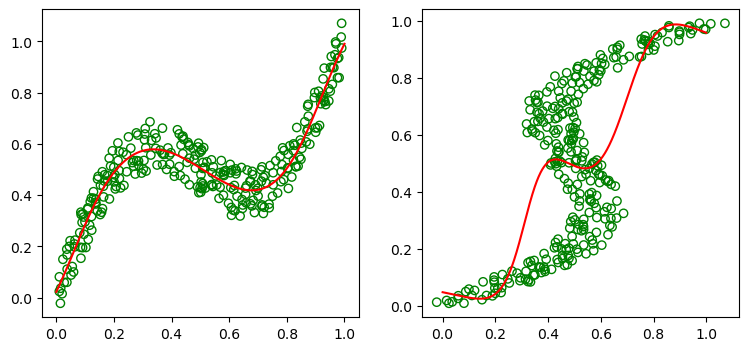

In [9]:
fig, (subplot1, subplot2) = plt.subplots(1,2, figsize=(9,4))
forward_model.eval().cpu()
inverse_model.eval().cpu()

subplot1.scatter(x, t, edgecolors='g', facecolors='none')
subplot2.scatter(t,x, edgecolors='g', facecolors='none')
inputs = np.linspace(0,1, 1000)
with torch.no_grad():
    input_tensors = [torch.tensor(i, dtype=torch.float32).unsqueeze(0) for i in inputs]
    
    forward_outputs = [forward_model(i).item() for i in input_tensors]
    subplot1.plot(inputs, forward_outputs, c='r')
    inverse_outputs = [inverse_model(i).item() for i in input_tensors]
    subplot2.plot(inputs, inverse_outputs, c='r')